In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import networkx as nx

In [2]:
from torch.autograd import Variable
from graspy.simulations import sbm

ModuleNotFoundError: No module named 'hyppo._utils'

# Experiments on Human Activity Recognition Dataset
The purpose of this notebook is to explore machine learning methods to do human activity recognition in federated settings. by using this dataset. https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones?select=train.csv

Data are collected from smartphone (Samsung Galaxy S II) accelerometer and gyroscope, 21 people wearing a smart phone on waist perform one of six activities: walking, walking-upstairs, walking-downstairs, sitting, standing and lying-down. The raw sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain. Ultimately, 561-length feature vectors of time and frequency domain variables are generated for each instance (as one datapoint).

We model each individual as a separate task and predict between sitting and the other activities (a binary classification problem). We formulate the problem as federated multi-task learning on graph. Each individual has 281-409 instance,i.e. 281-409 datappoints representing a local dataset associated with one node/vertex of the graph.




In [5]:
data = pd.read_csv('smart_sensor/train.csv')

In [6]:
data.Activity.unique()

array(['STANDING', 'SITTING', 'LAYING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [7]:
data.replace(['SITTING'],1,inplace=True)
# for the sake of simplification, we convert the task to a binary classification problem
data.replace(['WALKING_UPSTAIRS','STANDING', 'WALKING', 'LAYING','WALKING_DOWNSTAIRS'],0,inplace=True)

In [8]:
subject_array = data.subject.unique() # identitifier of 21 individual 

In [9]:
num_tasks = len(subject_array)
print('num of tasks:',num_tasks)

num of tasks: 21


## define models, optimizers, penalties

In [12]:
import torch
import abc
import torch.nn.functional as F

from abc import ABC


# The linear model which implemented by pytorch
class TorchLogModel(torch.nn.Module):
    def __init__(self, n):
        super(TorchLogModel, self).__init__()
        self.linear = torch.nn.Linear(n, 1, bias=False)

    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred
    
    
# The abstract optimizer model which should have model, optimizer, and criterion
class Optimizer(ABC):
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    @abc.abstractmethod
    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        torch_old_weight = torch.from_numpy(np.array(old_weight, dtype=np.float32))
        self.model.linear.weight.data = torch_old_weight
        for iterinner in range(5):
            self.optimizer.zero_grad()
            y_pred = self.model(x_data)
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear.weight - torch_old_weight) ** 2) 
            loss = loss1 + loss2
            loss.backward()
            self.optimizer.step()

        return self.model.linear.weight.data.numpy()
    
    
# The Linear optimizer model which implemented by pytorch    
class TorchLogOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.BCELoss(reduction='mean')
        optimizer = torch.optim.Adam(model.parameters())
        super(TorchLogOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        torch_old_weight = torch.from_numpy(np.array(old_weight, dtype=np.float32))
        self.model.linear.weight.data = torch_old_weight
        for iterinner in range(5):
            self.optimizer.zero_grad()
            y_pred = self.model(x_data)
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear.weight - torch_old_weight) ** 2) 
            loss = loss1 + loss2
            loss.backward()
            self.optimizer.step()

        return self.model.linear.weight.data.numpy()

In [13]:
# The abstract penalty function which has a function update
class Penalty(ABC):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        self.lambda_lasso = lambda_lasso
        self.weight_vec = weight_vec
        self.Sigma = Sigma

    @abc.abstractmethod
    def update(self, new_u):
        pass


# The norm2 penalty function
class Norm2Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm2Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array(lambda_lasso * weight_vec)

    def update(self, new_u):
        normalized_u = np.where(np.linalg.norm(new_u, axis=1) >= self.limit)
        new_u[normalized_u] = (new_u[normalized_u].T * self.limit[normalized_u] / np.linalg.norm(new_u[normalized_u], axis=1)).T
        return new_u


# The MOCHA penalty function
class MOCHAPelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(MOCHAPelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.normalize_factor = 1 + np.dot(2 * self.Sigma, 1/(self.lambda_lasso * self.weight_vec))

    def update(self, new_u):
        for i in range(new_u.shape[1]):
            new_u[:, i] /= self.normalize_factor

        return new_u

    
# The norm1 penalty function
class Norm1Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm1Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array([np.zeros(n) for i in range(len(weight_vec))])
        for i in range(n):
            self.limit[:, i] = lambda_lasso * weight_vec

    def update(self, new_u):
        normalized_u = np.where(abs(new_u) >= self.limit)
        new_u[normalized_u] = self.limit[normalized_u] * new_u[normalized_u] / abs(new_u[normalized_u])
        return new_u


In [14]:
from torch.autograd import Variable
from graspy.simulations import sbm


def get_B_weight_vec(num_nodes,num_edges):
    '''
    :param num_nodes: number of nodes
    :param num_edges: number of edges
    
    :return B: incidence matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    '''
   
    N = num_nodes
    E = num_edges
    '''
    N: total number of nodes
    E: total number of edges
    '''
        
    # create B(adjacency matrix) and edges's weights vector(weight_vec) based on the graph G
    B = np.zeros((E, N))
    '''
    B: incidence matrix of the graph with the shape of E*N
    '''
    weight_vec = np.zeros(E)
    '''
    weight_vec: a list containing the edges's weights of the graph with the shape of E
    '''
    
    cnt = 0
    for i in range(N):
        for j in range(N):
            if i >= j:
                continue
            B[cnt, i] = 1
            B[cnt, j] = -1

            weight_vec[cnt] = 0.01
            cnt += 1
    
    return B, weight_vec

In [15]:
def total_loss(datapoints,new_w,new_B,new_weight_vec):
   '''
   Total loss of the graph structure learning algorithm
   '''
    
    loss=0
    N = new_w.shape[0]
    
    for i in range(N):
        y = datapoints[i]['label']
        model = datapoints[i]['model']
        model.linear.weight.data = torch.from_numpy(np.array(new_w[i], dtype=np.float32))
#         print(model.linear.weight)
#         print(new_w[i])
        y_pred = model(datapoints[i]['features'])
        criterion = torch.nn.MSELoss(reduction='mean')
        
        loss += criterion(y,y_pred)
    loss = loss+np.dot(new_weight_vec,np.linalg.norm(new_B.dot(new_w),ord=1,axis=1))
    return loss

IndentationError: unexpected indent (<ipython-input-15-1feeb7ccb3f3>, line 6)


## Generate local datasets from the csv file


To simulate the fact that the amount of training data is usually insufficient, we randomly selected 100 datapoints as training data for each local datatset.The left datapoints will be used for test.

In [39]:
from sklearn.preprocessing import MinMaxScaler
def generate_datapoints(data):
    '''
    Input
       data: dataframe storing all datasets
    Output
       datapoints: a dictionary containing the attributes for each node in the graph,
       which are features, label, model, and also the optimizer for each node
    '''
    datapoints = {}
    subject_array = data.subject.unique()
    scaler = MinMaxScaler()
    for i,subject in enumerate(subject_array):
        temp = data[data.subject==subject]
        temp = temp.sample(frac=1,replace=True).reset_index(drop=True) #shuffle the dataset
        features = np.array(temp.drop(['subject','Activity'],axis=1))
        features = scaler.fit_transform(features)
#         print(len(features))
        labels=np.array(temp.Activity)
        n = features.shape[1]

        model = TorchLogModel(n)
        '''
        model : the logistic model for the node i that is implemented by pytorch
        '''
        optimizer = TorchLogOptimizer(model)
        '''
        optimizer : the optimizer model for the node i that is implemented by pytorch with BCE loss function
        '''

        datapoints[i] = {
            'features': Variable(torch.from_numpy(features[:100,:])).to(torch.float32),
            'model': model,
            'label': Variable(torch.from_numpy(labels[:100])).to(torch.float32),
            'optimizer': optimizer,
            
            'features_val': Variable(torch.from_numpy(features[100:150,:])).to(torch.float32),
            'label_val': Variable(torch.from_numpy(labels[100:150])).to(torch.float32),
            'features_test': Variable(torch.from_numpy(features[150:,:])).to(torch.float32),
            'label_test': Variable(torch.from_numpy(labels[150:])).to(torch.float32)
        }
    return datapoints

In [40]:
datapoints = generate_datapoints(data)
datapoints[2]

{'features': tensor([[0.7759, 0.4274, 0.2338,  ..., 0.0640, 0.8728, 0.7383],
         [0.6281, 0.4089, 0.3529,  ..., 0.0312, 0.8416, 0.9055],
         [0.5920, 0.3987, 0.3770,  ..., 0.1896, 0.9961, 0.9165],
         ...,
         [0.6060, 0.4263, 0.2402,  ..., 0.3874, 0.4906, 0.1158],
         [0.5829, 0.4197, 0.3356,  ..., 0.9609, 0.0529, 0.1275],
         [0.6463, 0.4877, 0.3634,  ..., 0.0326, 0.8443, 0.8947]]),
 'model': TorchLogModel(
   (linear): Linear(in_features=561, out_features=1, bias=False)
 ),
 'label': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
         0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]),
 'optimizer': <__main__

## Algorithms

In [20]:
def learn_graph_structure(K1,K2, graph,learning_rate, lambda_lasso=1, penalty_func_name='norm1', get_loss=False):
    '''
    The algorithm to learn datasets relationships.
    Inputs
        K1: out iteration numbers
        K2: inner iteration numbers
        graph: graph with node attributes setted up
    Outputs:
        new_weight_vec: updated dual variable
        Loss: iteration loss
    '''
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)
    B, weight_vec = get_B_weight_vec(num_nodes,num_edges)
    Sigma = np.diag(np.full(weight_vec.shape, 0.9 / 2))
    T_matrix = np.diag(np.array((1.0 / (np.sum(abs(B), 0)))).ravel())
    '''
    T_matrix: the block diagonal matrix T
    '''

    E, N = B.shape
    '''
    shape of the graph
    '''
    m, n = graph.nodes[1]['features'].shape
    '''
    shape of the feature vectors of each node in the graph
    '''

    new_w = np.array([np.zeros(n) for i in range(N)])
    
    new_u = np.array([np.zeros(n) for i in range(E)])
    new_weight_vec = weight_vec
    
    
    Loss = {}
    iteration_scores = []
    for j in range(K1):
        
        new_B = np.dot(np.diag(new_weight_vec),B)
        T_matrix = np.diag(np.array((1 / (np.sum(abs(B), 0)))).ravel())
        T = np.array((1 / (np.sum(abs(B), 0)))).ravel()
        
        
        for iterk in range(K2):
            # if iterk % 100 == 0:
            #     print ('iter:', iterk)

            prev_w = np.copy(new_w)

            # line 2 algorithm 1
            hat_w = new_w - np.dot(T_matrix, np.dot(new_B.T, new_u))


            for i in range(N):
                optimizer = graph.nodes[i]['optimizer']
                new_w[i] = optimizer.optimize(graph.nodes[i]['features'],graph.nodes[i]['label'], hat_w[i],T[i])

            tilde_w = 2 * new_w - prev_w
            new_u = new_u + np.dot(Sigma, np.dot(new_B, tilde_w))

            penalty_func = Norm1Pelanty(lambda_lasso, new_weight_vec, Sigma, n)
            new_u = penalty_func.update(new_u)
        new_weight_vec = new_weight_vec +learning_rate*np.linalg.norm(np.dot(B, new_w),ord=1,axis=1)
        if get_loss==True:
            Loss[j] = total_loss(graph.nodes,new_w,new_B,new_weight_vec)

    return new_weight_vec,Loss

In [21]:

from sklearn.metrics import mean_squared_error


def algorithm_1(K,graph,lambda_lasso, penalty_func_name='norm1', calculate_score=False):
    '''
    :param K: the number of iterations
    :param D: the block incidence matrix
    :param graph: a graph with node attributes setted up
    :param lambda_lasso: the parameter lambda
    :param penalty_func_name: the name of the penalty function used in the algorithm

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''
    num_nodes = len(graph.nodes)
    num_edges = len(graph.edges)
    D = np.zeros((num_edges,num_nodes))
    for i,e in enumerate(graph.edges):
        D[i,e[0]]=1
        D[i,e[1]]=-1
#     D, _ = get_B_weight_vec(num_nodes,num_edges)
    weight_vec = np.array(list(nx.get_edge_attributes(graph,'weight').values()))
    Sigma = np.diag(np.full(weight_vec.shape, 0.9 / 2))
    '''
    Sigma: the block diagonal matrix Sigma
    '''
    T_matrix = np.diag(np.array(1.0 / (np.sum(abs(D), 0))).ravel())
      
    '''
    T_matrix: the block diagonal matrix T
    '''
    T = np.array(1.0 / (np.sum(abs(D), 0))).ravel()
#     T = np.ones(num_nodes)*0.5

#     T_matrix = np.eye(num_nodes)*0.5
    E, N = D.shape
    m, n = graph.nodes[0]['features'].shape

    # define the penalty function
    if penalty_func_name == 'norm1':
        penalty_func = Norm1Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'norm2':
        penalty_func = Norm2Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'mocha':
        penalty_func = MOCHAPelanty(lambda_lasso, weight_vec, Sigma, n)

    else:
        raise Exception('Invalid penalty name')

    # starting algorithm 1

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the primal variable of the algorithm 1
    '''
    new_u = np.array([np.zeros(n) for i in range(E)])
    '''
    new_u: the dual variable of the algorithm 1
    '''

    iteration_scores = []
    for iterk in range(K):
        prev_w = np.copy(new_w)

        hat_w = new_w - np.dot(T_matrix, np.dot(D.T, new_u))
        for i in range(N):
                optimizer = graph.nodes[i]['optimizer']
#                 datapoints[i]['optimizer']
                new_w[i] = optimizer.optimize(graph.nodes[i]['features'],
                                              graph.nodes[i]['label'], 
                                              hat_w[i],T[i])

        
        tilde_w = 2 * new_w - prev_w
        new_u = new_u + np.dot(Sigma, np.dot(D, tilde_w))

        new_u = penalty_func.update(new_u)

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(graph.nodes[i]['features'], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w

## run experiments

### datasets relationships
#### learn relations via dual-ascent 

In [45]:
g = nx.complete_graph(21)             # we assume a fully connected graph initially
nx.set_node_attributes(g,datapoints)  # set up the graph with a dictionary datapoints generated from raw datsets

In [47]:
# Learn edge weights from datasets associated with nodes
new_weight_vec,_ = learn_graph_structure(5,300,g,0.01,1)  

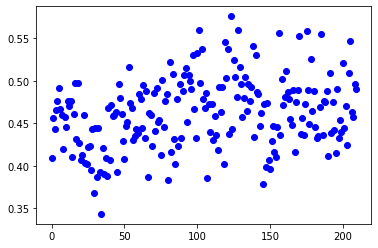

In [48]:
# Inverse of the learned dual variables as weights associated with graph edges
learned_weight_vec = np.exp(-new_weight_vec/1) 
plt.plot(learned_weight_vec,'bo')  

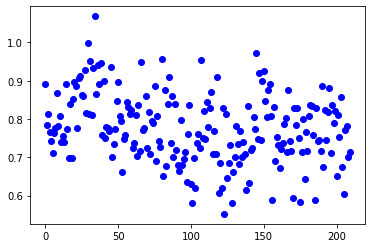

In [49]:
plt.plot(new_weight_vec,'bo')  

<ul style="color:black;font-size:25px">
  <li>Should I threshold the learned edge weights? </li>
  <br>  
    
  <li>After thresholding, some nodes will become isolated nodes, can we allow this?</li>
</ul>

In [ ]:
thresh_weight_vec = np.exp(-new_weight_vec)
thresh_weight_vec[thresh_weight_vec<0.4]=0

In [ ]:
def generate_similarity_matrix(weight_vector):
    '''
    Generate similarity matrix from the learned weight vector
    '''
    
    similarity_matrix = np.zeros((21,21))
    cnt=0
    for i in range(21):
        similarity_matrix[i,i+1:]=weight_vector[cnt:cnt+20-i]
        cnt+=20-i
    return similarity_matrix+similarity_matrix.T
    

In [ ]:
similarity_matrix =  generate_similarity_matrix(thresh_weight_vec)

In [ ]:
import seaborn as sns

In [ ]:
thresh_weight_vec.shape

In [ ]:
plt.plot(learned_weight_vec,'bo')

In [ ]:
np.sum(similarity_matrix,axis=0)

In [ ]:
sns.heatmap(similarity_matrix,annot=None)

#### visulize dataset relations via T-sne

In [ ]:
features = data.drop(['subject','Activity'],axis=1)
subject_temp = data.subject
tsne = TSNE(2)
feat_tsne = tsne.fit_transform (features) 

feat_tsne = pd.DataFrame(feat_tsne)
feat_tsne["subject"] = subject_temp
print(feat_tsne.shape)

In [ ]:
figure = plt.figure(figsize=(12,12))
for i,sub in enumerate(subject_array[[6,7,5]]):   
    print(i)
    plt.scatter(feat_tsne[feat_tsne["subject"]==sub].iloc[:,0],
                feat_tsne[feat_tsne["subject"]==sub].iloc[:,1],
               label=str(i)) 
    plt.legend()

#### obtain relation via KNN

In [ ]:
accuracy = []
for i in subject_array[0:]:
    for j in subject_array[0:]:
        if i>=j:
            continue
        knn = KNeighborsClassifier(5)
        X = data[data.subject.isin([i,j])]
#         print(i,j)
        
        knn.fit(X.iloc[:,:-2],X.iloc[:,-2])
        score = knn.score(X.iloc[:,:-2],X.iloc[:,-2])
        accuracy.append(score)
accus = np.array(accuracy)

In [ ]:
learned_weight_vec = accus

### learn tailored predictor for each local dataset


In [26]:
def update_graph_weight(g,weight_vector,sparse=True,threshold=None):
    if sparse:
        ind = np.argwhere(weight_vector<threshold)
        weigh = {}
    for i,e in enumerate(g.edges(data=False)):
        if i in ind:
            g.remove_edge(*e)
            continue
        else:
            ran = np.random.rand(1)
            if ran>0.5:
                g.remove_edge(*e)
                continue
            weigh[e] = {'weight':weight_vector[i]}
    nx.set_edge_attributes(g,weigh)
    return g 

In [ ]:
# Run the main algorithm to obtain hypothesis function weights for local datasets, 
# in this case, a tailored logistic regression model for each local dataset.


In [27]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

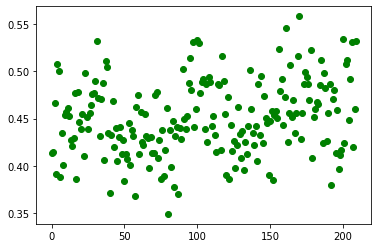

In [28]:
plt.plot(learned_weight_vec,'go')

In [50]:
g = update_graph_weight(g,learned_weight_vec,sparse=True,threshold=0.42)

In [51]:
# Calculate the averaged accuracy on test sets

for lambd in [0.01]:
    print(lambd)
    _, new_w = algorithm_1(3000,g,lambd)
    accus = []
    for i in range(21):
        y_pred=sigmoid(np.dot(g.nodes[i]['features_test'],new_w[i]))

        y_pred = [1 if i>=0.5 else 0 for i in y_pred]

        accu = 1-np.sum(abs(y_pred-g.nodes[i]['label_test'].numpy()))/len(y_pred)
        accus.append(accu)
    print('accuracy on test sets:', np.mean(accus))

0.01
accuracy on test sets: 0.990051921100478


In [52]:
# Calculate the averaged accuracy on test sets

for lambd in [0.001,0.01,0.1,1,5,10]:
    print(lambd)
    _, new_w = algorithm_1(3000,g,lambd)
    accus = []
    for i in range(21):
        y_pred=sigmoid(np.dot(g.nodes[i]['features_val'],new_w[i]))

        y_pred = [1 if i>=0.5 else 0 for i in y_pred]

        accu = 1-np.sum(abs(y_pred-g.nodes[i]['label_val'].numpy()))/len(y_pred)
        accus.append(accu)
    print('accuracy on val sets:', np.mean(accus))

0.001
accuracy on val sets: 0.9800000000000001
0.01
accuracy on val sets: 0.9933333333333333
0.1
accuracy on val sets: 0.9723809523809527
1
accuracy on val sets: 0.9733333333333334
5
accuracy on val sets: 0.9733333333333334
10
accuracy on val sets: 0.9733333333333334


## locally fitted logistic regression for each node seperately
Local logistic regression models were fitted to each local dataset seperately to provide a baseline. Gridsearchs were executed to select the best hyper-parameters, for each model using 5-fold cross-validation. The averaged accuracy is around 97%. 

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [46]:
## Gridsearch for the best hyper-parameters for each local Logistic regression model
## for each model using 5-fold cross-validation
## Calculate accuracy on test sets
accus_test = []
accus_val = []
for i in range(21):
    grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"],"solver":['liblinear']}
    
    logreg=LogisticRegression()
    logreg_cv=GridSearchCV(logreg,grid,cv=5)

    X = torch.cat((datapoints[i]['features'],datapoints[i]['features_val']))
    y = torch.cat((datapoints[i]['label'],datapoints[i]['label_val']))
    best_clf =logreg_cv.fit(X,y)
    accu_test = best_clf.score(g.nodes[i]['features_test'],g.nodes[i]['label_test'].squeeze())
    accus_test.append(accu_test)
    
    accu_val = best_clf.best_score_
    accus_val.append(accu_val)
print('mean accuracy on test sets:',np.mean(accus_test))
print('mean accuracy on val sets:',np.mean(accus_val))

mean accuracy on test sets: 0.9859225450679552
mean accuracy on val sets: 0.9885714285714287


In [ ]:
## Gridsearch for the best hyper-parameters for each local Logistic regression model
## for each model using 5-fold cross-validation
## Calculate accuracy on test sets
accus_test = []
accus_val = []
for i in range(21):
    grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"],"solver":['liblinear']}
    
    logreg=LogisticRegression()
    logreg_cv=GridSearchCV(logreg,grid,cv=3)

    X = torch.cat((datapoints[i]['features'],datapoints[i]['features_val']))
    y = torch.cat((datapoints[i]['label'],datapoints[i]['label_val']))
    best_clf =logreg_cv.fit(X,y)
    accu_test = best_clf.score(g.nodes[i]['features_test'],g.nodes[i]['label_test'].squeeze())
    accus_test.append(accu_test)
    
    accu_val = best_clf.best_score_
    accus_val.append(accu_val)
print('mean accuracy on test sets:',np.mean(accus))
print('mean accuracy on val sets:',np.mean(accus_val))

In [ ]:
data.head()